In [1]:
import identification as ob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import control as con
import warnings
import glob #for returning files having the specified path extension
import time
import statistics as stats
import os #checking for empty file
start_time = list(time.localtime())[5] 
#returns the local time at the start of execution. Can be used to calculate the execution time manually
%pylab inline
warnings.filterwarnings('ignore') 
#ignores all the warnings that may arise during runtime

Populating the interactive namespace from numpy and matplotlib


/home/ipa325/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


###### Passing all the data into arrays 

In [2]:
task_first        = sorted(glob.glob('step_log/*/*task*.log')) #corresponds to .log files that has data related to the first position
control_first     = sorted(glob.glob('step_log/*/*control*.log'))
task_remaining    = sorted(glob.glob('step_log/*/*task*.log.*')) #corresponds to remaining log.'n' files
control_remaining = sorted(glob.glob('step_log/*/*control*.log.*'))
task              = sorted(task_first + task_remaining) #set of all task_velocity logs
control           = sorted(control_first + control_remaining) #set of all control logs
observations      = len(task_first) #total number of experiments conducted/observations taken
positions         = int(len(task) / observations) #number of points in the given task space
task_full         = [] #A task_velocity list whose each element is a list of similar log files i.e from the same position
control_full      = [] #A control_output list whose each element is a list of similar log files i.e from the same position

for i in range(0, positions):
    task_full.append([])
    control_full.append([])
    for j in range(0, observations):
        task_full[i].append(task[i + (j * positions)])
        control_full[i].append(control[i + (j * positions)])

        new_obs = observations

In [3]:
count = 0 #counter that returns the number of empty files
for i in range(0, positions):
    for j in range(0, observations):
        if os.stat(task_full[i][j]).st_size == 0:
            count = count + 1
            
for i in range(0, positions):
    for j in range(0, observations-count):
        if os.stat(task_full[i][j]).st_size == 0:
            del(task_full[i][j])
            del(control_full[i][j])

###### Reading all the data into a dataset array

In [4]:
df_ist_soll = []
for i in range(0,positions):
    df_ist_soll.append([])
    for j in range(0,observations):
        try:
            df_ist_soll[i].append(ob.batch_read_data(control_full[i][j],task_full[i][j]))
        except:
            continue

In [18]:
len(task_full)

9

###### Observing log data

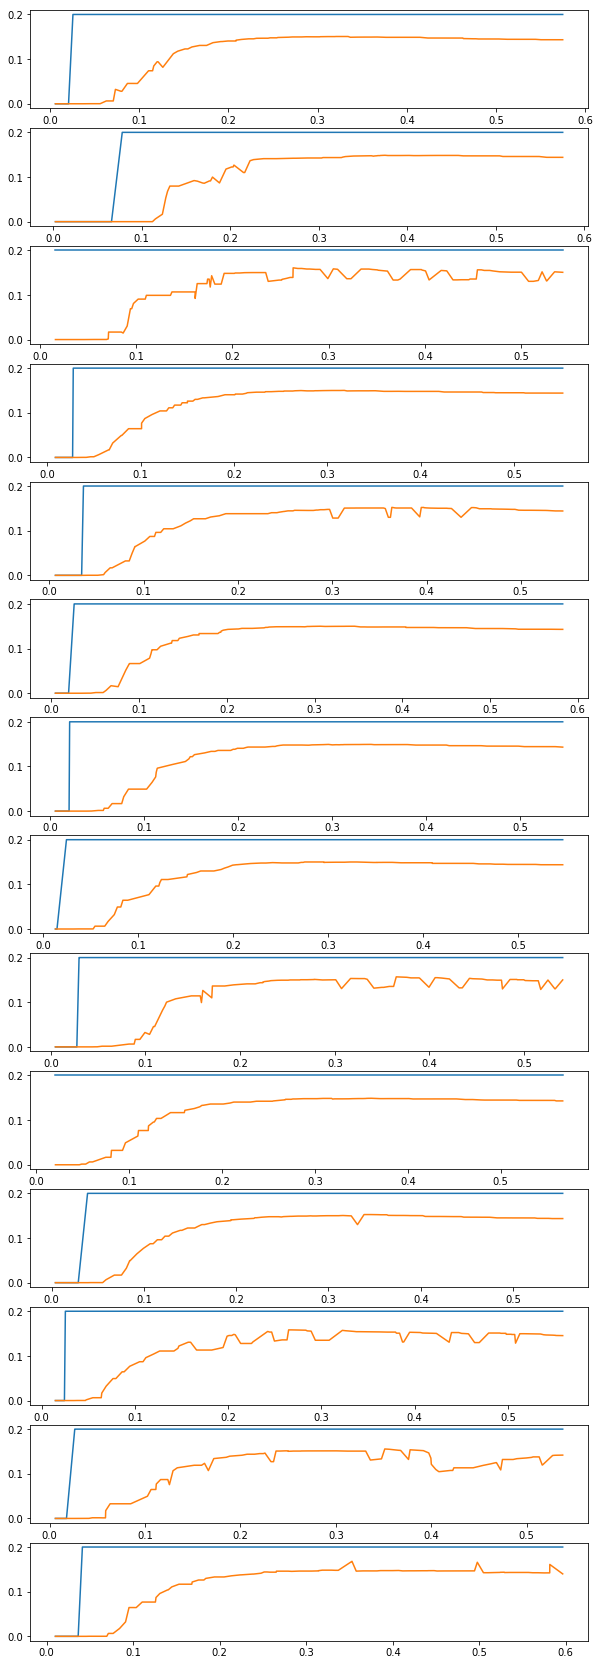

In [33]:
plt.figure(figsize=(10,30))
for i in range(0, len(df_ist_soll[0])): #len(task_full)
    try:
        plt.subplot(len(df_ist_soll[0]), 1, i+1)
        plt.plot(df_ist_soll[0][i]) #change 0 from 0 to position-1 to observe the incoming data 
    except:
        pass
    #plt.savefig('1.png')

In [6]:
%load_ext rpy2.ipython

In [7]:
%%R 
library(stats) 
#for using the ar() function
library(forecast) 
#for using the fitted.values() function

In [8]:
def identify(df):
    #Removing all zeros & the negative trend and reformatting the data in accordance with a unit step response
    xin_array, yout_array, t_array = ob.strip_multiply(df) 
    #The function returns the aic,mse and fitted values for a given output data and a given order 
    def order_ar_R(ar_order, output):
        %R -i ar_order,output 
        #data is inputed as a list vector. In a list vector, each element in the list is an array. No space can be provided after comma. If provided, it results in 'NameError: name '' is not defined' error.
        %R output                 = unlist(output)  
        #converts the list vector back into a single array. Need this step in latest R version 3.4.2.
        %R ar_system              = ar(output, method = "ols", order.max = ar_order)
        %R fitted_ar_with_missing = fitted.values(ar_system) 
        #the lower values in the output data contributes to NA/missing values in the fitted values. This corresponds to the delay in the output data.
        %R -o fitted_ar_with_missing

        fitted_ar_without_missing = np.nan_to_num(fitted_ar_with_missing) 
        #the missing values becomes nan values in Python and they are converted to 0. It becomes easier in finding the delay for our model.
        mse_ar = mean_squared_error(output,fitted_ar_without_missing)

        %R -i mse_ar
        %R output_length = length(output) 
        %R aic_ar        = (output_length * log(mse_ar)) + (2 * ar_order) + (output_length * dim(matrix(output))[2] * (log(2 * pi) + 1)) #result obtained from https://rdrr.io/cran/sysid/src/R/estpoly.R
        %R -o aic_ar,mse_ar

        return list(aic_ar), mse_ar, fitted_ar_without_missing

    order_ar_P = ob.order_ar_P #AR prediction using Python

    #The function returns a dataframe that contains the aic,mse and order values from 1 to 10 along with the fitted values for each order 
    def order_aic_mse_fit(yout):
        aic                  = []
        order                = []
        mse                  = []
        fit_values           = []
        aic_mse_fit_df       = [] 
        aic_mse_fit_df.append([])
        #2D array in which each element stores two floats(aic and mse) and an array(fit_values)

        for i in range(1,11):
            order.append(i)
            aic_mse_fit_df.append(order_ar_R(i,yout)) #change order_ar_R to order_ar_P to perform AR prediction in Python
            aic.append(aic_mse_fit_df[i][0])
            mse.append(aic_mse_fit_df[i][1])
            fit_values.append(aic_mse_fit_df[i][2])

        df = pd.DataFrame(np.column_stack([order, aic, mse]),\
                          columns=['order', 'aic', 'mse']) 
        #all variables are passed into the dataframe as type float by default  
        return df, fit_values


    df_fit_array = []
    df_array = []
    fit_val = []

    for i in range(0, len(yout_array)):
        df_fit_array.append(order_aic_mse_fit(yout_array[i]))
        df_array.append(df_fit_array[i][0])
        fit_val.append(df_fit_array[i][1])

    #oma_best is an array that contains order, mse and aic values of the best fit data
    oma_best    = []
    mse_best    = []
    aic_best    = []
    order_best  = []
    fitted_best = []

    for i in range(0, len(df_fit_array)):
        oma_best.append(list(df_array[i][df_array[i].mse == df_array[i].mse.min()].values[0]))
        order_best.append(oma_best[i][0])
        mse_best.append(oma_best[i][1])
        aic_best.append(oma_best[i][2])    
        fitted_best.append(fit_val[i][int(order_best[i]) - 1])    

        
    '''Smoothing of fitted data'''
    smooth_1 = []

    for i in range(0, len(fitted_best)):
        smooth_1.append(ob.smooth(fitted_best[i], 1))
        
    
    '''PT1 modeling'''
    #youto,to are the yout and t outputs from the pt1 and pt2 system
    #tf and delay are the transfer functions of the output and its delay
    #tdytdts is an array that contains all the above values in a sequential order
    to_1           = []
    tf_1           = []
    zeta           = []
    youto_1        = []
    delay_1        = []
    tdytdts_1      = []
    delay_tf_1     = []
    steady_state_1 = []
    time_constant_1 = []
    
    for i in range(0,len(smooth_1)):
        tdytdts_1.append(ob.pt1(smooth_1[i], t_array[i]))
        tf_1.append(tdytdts_1[i][0])
        youto_1.append(tdytdts_1[i][1])
        to_1.append(tdytdts_1[i][2])
        delay_1.append(tdytdts_1[i][3])
        time_constant_1.append(tdytdts_1[i][4])
        steady_state_1.append(tdytdts_1[i][5])
    
    
    
    return steady_state_1, time_constant_1, delay_1, xin_array, yout_array, t_array

###### Plotting of ideal model from each point in the task space

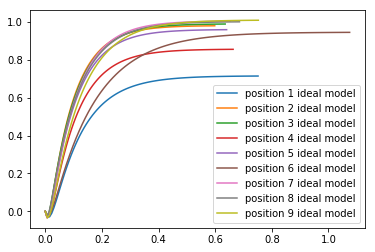

In [9]:
system_matrix = []
mean_matrix   = []
median_matrix = []
std_matrix    = [] #std = standard deviation
var_matrix    = [] 
model_pos     = []
for i in range(0, positions):
    try:
        steady_state_1, time_constant_1, delay_1, xin_array, yout_array, t_array = identify(df_ist_soll[i])
    except:
        continue
    ideal_tf_pt1, ideal_model_output_pt1, ideal_model_time_pt1 = ob.ideal_pt1(steady_state_1, time_constant_1, delay_1)
    model_pos.append(ideal_model_output_pt1)
    mean_matrix.append(stats.mean(ideal_model_output_pt1))
    median_matrix.append(stats.median(ideal_model_output_pt1))
    std_matrix.append(stats.pstdev(ideal_model_output_pt1))
    var_matrix.append(stats.variance(ideal_model_output_pt1))
    plt.plot(ideal_model_time_pt1, ideal_model_output_pt1, label = 'position %s ideal model'%(i+1))
    plt.legend()
    plt.savefig('model.png')
    system_matrix.append(ob.ss(ideal_tf_pt1))

In [10]:
end_time = list(time.localtime())[5]
s=np.subtract(end_time, start_time)
print('Total execution time is ',abs(s),' seconds')

Total execution time is  32  seconds
